# GAN_descriminator_experiments

* check if the descriminator is generalizable

In [11]:
# general tools
import sys
from glob import glob

# data tools
import numpy as np
from random import shuffle

# deep learning tools
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

# graph tools
import matplotlib.pyplot as plt
%matplotlib inline

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/')
from namelist import *
import data_utils as du
import model_utils as mu
import train_utils as tu

In [12]:
import importlib
importlib.reload(mu)

<module 'model_utils' from '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/model_utils.py'>

# Global settings

In [13]:
sea = 'jja' # testing in the JJA season
N_input = 3 # LR T2, HR elev, LR elev
VAR = 'TMEAN'

N = [56, 112, 224, 448] # number of channels per downsampling level
l = [1e-4, 2e-4] # G lr; D lr

# Keras models

**Generator**, initialized with pre-trained UNET weights

In [14]:
# load weights
model_name = 'UNET3_{}_{}_tune'.format(VAR, sea)
model_path = temp_dir+model_name+'.hdf'
print('Import model: {}'.format(model_name))
backbone = keras.models.load_model(model_path)
W = backbone.get_weights()

# generator
G = mu.UNET(N, (None, None, N_input))
# optimizer
opt_G = keras.optimizers.Adam(lr=l[0])

print('Compiling G')
G.compile(loss=keras.losses.mean_absolute_error, optimizer=opt_G)
G.set_weights(W)

Import model: UNET3_TMEAN_jja_tune
Compiling G


**Descriminator**, pre-trained

In [15]:
# load weights
model_name = 'GAN_D_{}_{}'.format(VAR, sea)
model_path = temp_dir+model_name+'.hdf'

print('Import model: {}'.format(model_name))
backbone = keras.models.load_model(model_path)
W = backbone.get_weights()

input_size = (None, None, N_input+1)
D = mu.vgg_descriminator(N, input_size)

opt_D = keras.optimizers.Adam(lr=l[1])
print('Compiling D')
D.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt_D)
D.set_weights(W)

Import model: GAN_D_TMEAN_jja
Compiling D


**GAN**

In [16]:
GAN_IN = keras.layers.Input((None, None, N_input))
G_OUT = G(GAN_IN)
D_IN = keras.layers.Concatenate()([G_OUT, GAN_IN])
D_OUT = D(D_IN)
GAN = keras.models.Model(GAN_IN, [G_OUT, D_OUT])

print('Compiling GAN')
# content_loss + 1e-3 * adversarial_loss
GAN.compile(loss=[keras.losses.mean_absolute_error, keras.losses.categorical_crossentropy], 
            loss_weights=[1.0, 1e-3],
            optimizer=opt_G)

Compiling GAN


# Train domain test

In [17]:
file_path = BATCH_dir
trainfiles = glob(file_path+'{}_BATCH_*_TORI*_{}*.npy'.format(VAR, sea)) # e.g., TMAX_BATCH_128_VORIAUG_mam30.npy
validfiles = glob(file_path+'{}_BATCH_*_VORI*_{}*.npy'.format(VAR, sea))
# shuffle filenames
shuffle(trainfiles)
shuffle(validfiles)
#
L_train = len(trainfiles)

In [18]:
epochs = 5
batch_size = 200

y_bad = np.zeros(batch_size)
y_good = np.ones(batch_size)
dummy_good = keras.utils.to_categorical(y_good)
dummy_mix = keras.utils.to_categorical(np.concatenate((y_bad, y_good), axis=0))

input_flag = [False, True, False, False, True, True] # LR T2, HR elev, LR elev
output_flag = [True, False, False, False, False, False] # HR T2
inout_flag = [True, True, False, False, True, True]
labels = ['batch', 'batch'] # input and output labels

gen_valid = tu.grid_grid_gen(validfiles, labels, input_flag, output_flag)

In [19]:
import time

In [20]:
#record = np.inf
min_del = 0.00001
max_tol = 3 # early stopping with 2-epoch patience
tol = 0

# loss backup
GAN_LOSS = np.zeros([int(epochs*L_train), 3])*np.nan
D_LOSS = np.zeros([int(epochs*L_train)])*np.nan
V_LOSS = np.zeros([epochs])
                  
for i in range(epochs):
    print('epoch = {}'.format(i))
    if i == 0:
        record = G.evaluate_generator(gen_valid, verbose=1)
        print('Initial validation loss: {}'.format(record))
        
    start_time = time.time()
    # learning rate schedule
    
    # shuffling at epoch begin
    shuffle(trainfiles)
    # loop over batches
    for j, name in enumerate(trainfiles):

        # import batch data
        temp_batch = np.load(name, allow_pickle=True)[()]
        X = temp_batch['batch'][...]

        # get G_output
        D.trainable = True
        g_in = X[..., input_flag]
        g_out = G.predict([g_in]) # <-- np.array

        # test D with G_output
        d_in_fake = np.concatenate((g_out, g_in), axis=-1) # channel last
        d_in_true = X[..., inout_flag]
        d_in = np.concatenate((d_in_fake, d_in_true), axis=0) # batch size doubled
        d_target = dummy_mix
        d_shuffle_ind = du.shuffle_ind(2*batch_size)
        d_loss = D.train_on_batch(d_in[d_shuffle_ind, ...], d_target[d_shuffle_ind, ...])

        # G training / transferring
        D.trainable = False
        gan_in = X[..., input_flag]
        gan_target = [X[..., output_flag], dummy_good]

        gan_loss = GAN.train_on_batch(gan_in, gan_target)
        # Backup training loss
        D_LOSS[i*L_train+j] = d_loss
        GAN_LOSS[i*L_train+j, :] = gan_loss
        #
        if j%100 == 0:
            print('\t{} step loss = {}'.format(j, gan_loss))
    # on epoch-end
    record_temp = G.evaluate_generator(gen_valid, verbose=1)
                  
    # Backup validation loss
    V_LOSS[i] = record_temp
    if record - record_temp > min_del:
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        # save
        #print('save to: ')
        #G.save
        #D.save
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        if tol >= max_tol:
            print('Early stopping')
            break;
        else:
            continue;
            
    print("--- %s seconds ---" % (time.time() - start_time))
    # mannual callbacks

epoch = 0
328/328 [==============================] - 80s 244ms/step - loss: 0.1218
Initial validation loss: 0.121833568734185
	0 step loss = [0.09364493, 0.090682946, 2.9619842]
	100 step loss = [0.07590298, 0.07583536, 0.067624494]
	200 step loss = [0.06917895, 0.069178484, 0.00046310015]
	300 step loss = [0.08624333, 0.0862173, 0.02603416]
	400 step loss = [0.09107561, 0.091063626, 0.01197927]
	500 step loss = [0.06555204, 0.06555203, 1.0757482e-05]
	600 step loss = [0.08892163, 0.08891756, 0.0040644626]
	700 step loss = [0.09121706, 0.091216095, 0.00096733903]
	800 step loss = [0.06757206, 0.06757205, 8.73821e-06]
	900 step loss = [0.072589494, 0.072589375, 0.00011726563]
328/328 [==============================] - 99s 303ms/step - loss: 0.1093
Validation loss improved from 0.121833568734185 to 0.10925981004881423
--- 2020.7207915782928 seconds ---
epoch = 1
	0 step loss = [0.0881509, 0.08812803, 0.022873025]


KeyboardInterrupt: 

In [ ]:
G.evaluate_generator(gen_valid, verbose=1)

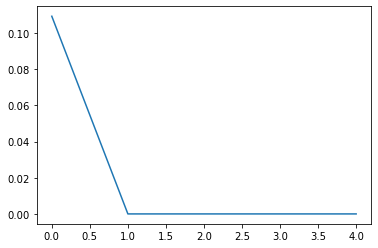

In [24]:
plt.plot(V_LOSS[:])

In [22]:
GAN_LOSS.shape

(4965, 3)